In [2]:
!pip install torch torchvision pillow matplotlib



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Step 100/500, Total loss: 20344248320.0000
Step 200/500, Total loss: 5998415872.0000
Step 300/500, Total loss: 3563161856.0000
Step 400/500, Total loss: 2795135488.0000
Step 500/500, Total loss: 2323385856.0000


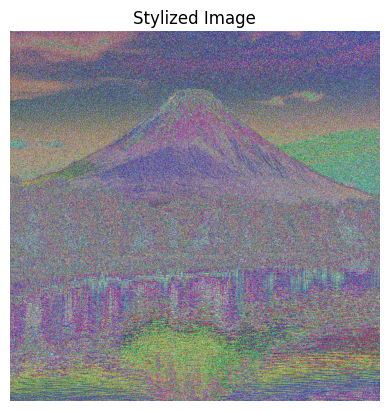

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import copy

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load and preprocess image ===
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')

    # Resize based on max_size or given shape
    if shape:
        size = shape  # (height, width)
    else:
        size = max(image.size) if max(image.size) > max_size else max(image.size)

    # Resize image properly
    in_transform = transforms.Compose([
        transforms.Resize(size if isinstance(size, tuple) else (size, size)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    image = in_transform(image).unsqueeze(0)
    return image.to(device)

# Convert tensor to image
def im_convert(tensor):
    image = tensor.clone().detach().to("cpu").squeeze(0)
    image = transforms.ToPILImage()(image)
    return image

# === Load content and style images ===
content = load_image(r"/content/sample_data/NST/content image.png")
style = load_image(r"/content/sample_data/NST/style image.png", shape=tuple(content.shape[-2:]))

# === Load VGG19 model ===
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Freeze VGG parameters
for param in vgg.parameters():
    param.requires_grad = False

# Define layers to use for style and content
style_layers = ['0', '5', '10', '19', '28']  # conv1_1 to conv5_1
content_layers = ['21']  # conv4_2

# === Extract features from VGG19 ===
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',
            '28': 'conv5_1'
        }

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# === Gram Matrix for style representation ===
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    return torch.mm(tensor, tensor.t())

# Get features for both content and style
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create target image (clone of content)
target = content.clone().requires_grad_(True).to(device)

# Weights
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.5,
    'conv4_1': 0.25,
    'conv5_1': 0.1
}

content_weight = 1e4  # alpha
style_weight = 1e2    # beta

# === Optimizer ===
optimizer = optim.Adam([target], lr=0.003)

# === Training loop ===
steps = 500  # Total iterations

for step in range(1, steps + 1):
    # Get target features
    target_features = get_features(target, vgg)

    # Compute content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    # Compute style loss
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        style_loss += layer_style_loss / (target_feature.shape[1] ** 2)

    # Total loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # Backpropagation
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Print progress
    if step % 100 == 0:
        print(f"Step {step}/{steps}, Total loss: {total_loss.item():.4f}")

# === Show final stylized image ===
final_img = im_convert(target)
plt.imshow(final_img)
plt.axis('off')
plt.title("Stylized Image")
plt.show()

# Optional: Save final image
final_img.save("/content/sample_data/NST/output_stylized.png")
